In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Load the EMNIST data
train_dict = pd.read_pickle('emnist_train.pkl')
test_dict = pd.read_pickle('emnist_test.pkl')

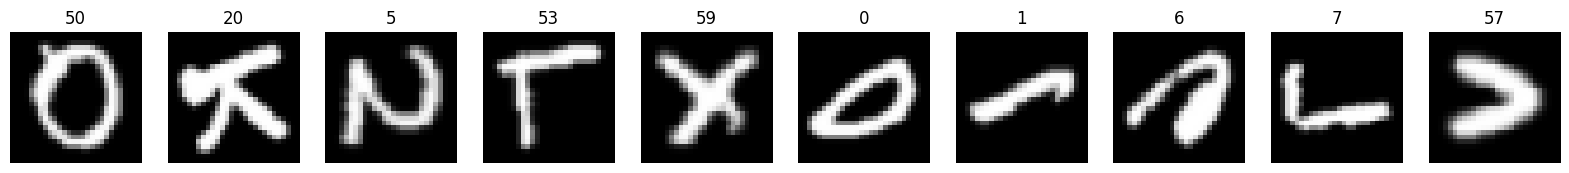

In [4]:
# Visualize the original data
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(train_dict['data'][i], cmap='gray')
    ax[i].set_title(train_dict['labels'][i])
    ax[i].axis('off')
plt.show()

In [5]:
# Convert the data to np arrays
train_images = np.array(train_dict['data'])
train_labels = np.array(train_dict['labels'])
test_images = np.array(test_dict['data'])
test_labels = np.array(test_dict['labels'])

# Add a channel dimension
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((tf.image.resize(train_images, [32, 32]), train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((tf.image.resize(test_images, [32, 32]), test_labels))
print("Train Dataset:", train_dataset)
print("Test Dataset:", test_dataset)

Train Dataset: <TensorSliceDataset shapes: ((32, 32, 1), ()), types: (tf.float32, tf.int64)>
Test Dataset: <TensorSliceDataset shapes: ((32, 32, 1), ()), types: (tf.float32, tf.int64)>


In [6]:
# CNN Model: VGG11
# Define VGG11 model
def VGG11(input_shape, num_classes=62):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    
    # Conv Layer Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer Block 2
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer Block 3
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer Block 4
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

In [7]:
# Create VGG11 model
vgg11_model = VGG11(input_shape=(32, 32, 1), num_classes=62)

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
loss = keras.losses.SparseCategoricalCrossentropy()
vgg11_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

vgg11_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0

In [8]:
# Train the model
history = vgg11_model.fit(train_dataset.batch(64), validation_data=test_dataset.batch(64), epochs=10)

Epoch 1/10
1563/1563 [==============================] - 237s 134ms/step - loss: 1.6379 - accuracy: 0.5833 - val_loss: 0.7217 - val_accuracy: 0.7757
Epoch 2/10
1563/1563 [==============================] - 171s 109ms/step - loss: 0.8035 - accuracy: 0.7498 - val_loss: 0.5715 - val_accuracy: 0.8124
Epoch 3/10
1563/1563 [==============================] - 41s 27ms/step - loss: 0.6529 - accuracy: 0.7868 - val_loss: 0.5043 - val_accuracy: 0.8285
Epoch 4/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.5767 - accuracy: 0.8065 - val_loss: 0.4706 - val_accuracy: 0.8382
Epoch 5/10
1563/1563 [==============================] - 13s 9ms/step - loss: 0.5279 - accuracy: 0.8187 - val_loss: 0.4509 - val_accuracy: 0.8426
Epoch 6/10
1563/1563 [==============================] - 374s 239ms/step - loss: 0.4916 - accuracy: 0.8289 - val_loss: 0.4378 - val_accuracy: 0.8467
Epoch 7/10
1563/1563 [==============================] - 709s 453ms/step - loss: 0.4657 - accuracy: 0.8354 - val_loss: 0.

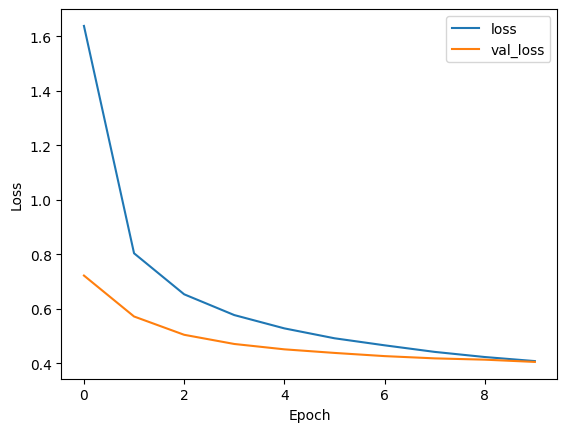

In [9]:
# Plot the loss vs epoch graph
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()